<a href="https://colab.research.google.com/github/alixintong/btt-ai-know-your-customer/blob/alice/bounding_box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this cell allows access to our folder

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_path = '/content/gdrive/MyDrive/BTTAI_AmericanExpress1'

Mounted at /content/drive


In [2]:
# cell for imports - add as needed
import torch 
import cv2
import numpy as np 
import pandas as pd
import os, os.path
import re
from fastai.vision.all import *

In [3]:
# for reference
#   - fastai segmentation: https://walkwithfastai.com/Segmentation
#   - fastai object detection: https://walkwithfastai.com/Object_Detection

In [4]:
path = '/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames'

files = get_image_files(path + "/datasheet001_frames")
len(files)

214

In [5]:
# import bounding box datasheet csv
# use datasheet001 as csv instead of xml
url='https://drive.google.com/file/d/1lUoBf1rwPXPlI9Zg2lDzwV4ODtsGJ4u2/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,_rejected
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,False
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,False
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,False
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,False
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,False


In [6]:
df["document"] = df["_rejected"].apply(lambda x: not x)

In [7]:
df = df.drop('_rejected', axis = 1)
df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,document
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,True
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,True
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,True
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,True
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,True


In [8]:
def get_coordinates(row_data):
  x1 = min(row_data[1], row_data[4], row_data[7], row_data[10])
  y1 = min(row_data[2], row_data[5], row_data[8], row_data[11])
  x2 = max(row_data[1], row_data[4], row_data[7], row_data[10])
  y2 = max(row_data[2], row_data[5], row_data[8], row_data[11])
  bb_cd = [x1, y1, x2, y2] 
  return bb_cd

In [9]:
bb = []
bb.append(df.apply(lambda row: get_coordinates(row), axis = 1))

In [11]:
bb = np.array(bb)
bb = bb.flatten()
bb = list(bb)

In [12]:
df_bb = pd.DataFrame(data=bb, columns=['x1', 'y1', 'x2', 'y2'])
df_bb.head()

,x1,y1,x2,y2
0,716.625,199.127,1259.02,805.609
1,714.326,200.028,1257.21,806.309
2,713.031,199.795,1255.42,804.811
3,713.845,196.852,1256.72,802.659
4,713.088,194.057,1259.35,802.830


In [13]:
df_bb['document'] = df['document']
df_bb.head() # df_bb would be the labels of bounding boxes

,x1,y1,x2,y2,document
0,716.625,199.127,1259.02,805.609,True
1,714.326,200.028,1257.21,806.309,True
2,713.031,199.795,1255.42,804.811,True
3,713.845,196.852,1256.72,802.659,True
4,713.088,194.057,1259.35,802.830,True


In [14]:
# get image names
os.chdir('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames')
imgs = os.listdir()

In [15]:
bbox = []
for i in range(0,214):
  e = [list(df_bb.iloc[i,0:4]), [df_bb.iloc[i,4]]]
  bbox.append(e)

In [16]:
# use a dictionary to quickly look up a corresponding image to it's label
img2bbox = dict(zip(imgs, bbox))

In [17]:
# a getter function
getters = [lambda o: o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]] # o is the input image name

In [18]:
# for transforms later
item_tfms = [Resize(128, method='pad'),] 
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [19]:
def get_train_imgs(noop): return imgs # simply return the images

In [20]:
frames = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock), # define pre-defined problem domains: images, bb, label bb
                 splitter=RandomSplitter(), 
                 get_items=get_train_imgs, 
                 getters=getters, # getters applied to results of get_items
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [21]:
frames.summary(os.getcwd())
files = get_image_files(os.getcwd())
files[:5]

Setting-up type transforms pipelines
Found 214 items
2 datasets of sizes 172,42
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> TensorBBox.create
Setting up Pipeline: <lambda> -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      datasheet001_frames_00073.jpg
    applying <lambda> gives
      datasheet001_frames_00073.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1920x1080
  Pipeline: <lambda> -> TensorBBox.create
    starting from
      datasheet001_frames_00073.jpg
    applying <lambda> gives
      [535.046, 201.203, 1054.09, 753.171]
    applying TensorBBox.create gives
      TensorBBox of size 1x4
  Pipeline: <lambda> -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}
    starting from
      datasheet001_frames_00073.jpg
    applying <lambda> gives
      [True]
    applying MultiCategorize -- {'vocab': None, 'sort':

(#5) [Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00001.jpg'),Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00002.jpg'),Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00003.jpg'),Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00004.jpg'),Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00005.jpg')]

In [22]:
dls = frames.dataloaders(files)

In [23]:
dls.c = 1

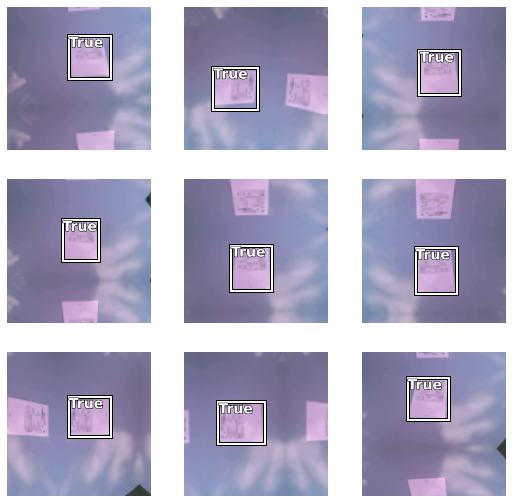

In [24]:
dls.show_batch()

In [27]:
#!pip install wwf
from wwf.vision.object_detection import *

In [29]:
encoder = create_body(resnet34(), pretrained=True)

In [30]:
# call RetinaNet architecture - pass in encoder, number of classes, and final bias on last convolutional layer
get_c(dls)

1

In [31]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [32]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [33]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [34]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [35]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [36]:
# loss function
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [37]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [38]:
# learner
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [39]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [40]:
learn.freeze()

In [41]:
# Training
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,3.680068,3.457086,01:43
1,3.499872,3.165926,01:40
2,2.977562,2.248234,01:39
3,2.687737,2.838647,01:37
4,2.472650,2.793158,01:38
5,2.319677,2.391312,01:38
6,2.149541,1.903899,01:40
7,2.044715,1.705064,01:40
8,1.962769,1.647363,01:39
9,1.885270,1.575182,01:38
